####  实验准备模块

In [23]:
# -- coding:gbk --
import sys
import os.path
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath("E://P-GPS Project/PGLP-master/test")))
sys.path.append(BASE_DIR)
print(sys.path)
import numpy as np
import matplotlib.pyplot as plt
import math
imgdir = "E://P-GPS Project/PGLP-master/img"
n_x_lattice = 50
sample_num = 2000
placeID = 3
#指定数据集选取的经纬度范围
min_lon, max_lon, min_lat, max_lat = 139.6, 139.75, 35.679, 35.8
#给定不同隐私预算
epsilons = [0.3, 0.5, 0.7, 1]
list_n_subgraph_x_nodes = [3,4,5]#对应k9是3*3，k16是4*4，k25是5*5
cat_n_subgraph_x_nodes = 6
graph_names = [f"G_k{num ** 2}" for num in list_n_subgraph_x_nodes]
graph_names.append(f"G_poi_k{cat_n_subgraph_x_nodes ** 2}")

['E:\\LDP-Data-publication-and-analysis-system\\TRLP-master\\test', 'E:\\LDP-Data-publication-and-analysis-system', 'D:\\Users\\juanrui\\Anaconda3\\envs\\LDP-project\\python37.zip', 'D:\\Users\\juanrui\\Anaconda3\\envs\\LDP-project\\DLLs', 'D:\\Users\\juanrui\\Anaconda3\\envs\\LDP-project\\lib', 'D:\\Users\\juanrui\\Anaconda3\\envs\\LDP-project', '', 'D:\\Users\\juanrui\\Anaconda3\\envs\\LDP-project\\lib\\site-packages', 'D:\\Users\\juanrui\\Anaconda3\\envs\\LDP-project\\lib\\site-packages\\win32', 'D:\\Users\\juanrui\\Anaconda3\\envs\\LDP-project\\lib\\site-packages\\win32\\lib', 'D:\\Users\\juanrui\\Anaconda3\\envs\\LDP-project\\lib\\site-packages\\Pythonwin', 'D:\\Users\\juanrui\\Anaconda3\\envs\\LDP-project\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\juanrui\\.ipython', 'E:\\P-GPS Project', 'E:\\LDP-Data-publication-and-analysis-system\\TRLP-master\\src', '../src', 'D:\\Program Files\\JetBrains\\PyCharm 2021.1.3\\plugins\\python\\helpers\\pydev', 'D:\\Program Files\\JetB

In [24]:
import sys
sys.path.append("E:\LDP-Data-publication-and-analysis-system\TRLP-master\src")
import trajectory_processor
import map_processor
import mechanism_with_policy_graph
import os
import numpy as np
import math
import time
#单个轨迹的扰动算法
def perturb_trajectory(traj, traj_processor, epsilon, mec, iter_num=1, initial_constraint_domain_tp=None):
    reports = {"true_trajectory": traj[:1], "perturbed_trajectories": []}
    mec.policy_mat = traj_processor.graph_mat
    for f in range(iter_num):
        #print("-"*25+"第"+str(f+1)+"次"+"-"*25)
        #traj表示一个用户的轨迹
        if initial_constraint_domain_tp:#如果约束域非空
            #初始约束域
            initial_constraint_domain = initial_constraint_domain_tp.areas[initial_constraint_domain_tp.state_to_area_state(traj[0])]
            prob = 1/len(initial_constraint_domain) #初始概率为约束域中元素个数分之一
            #先验概率分布
            prior_distribution = np.zeros(len(traj_processor.transition_mat[0])) #先验概率长度为网格坐标个数N
            prior_distribution[np.array(initial_constraint_domain)] = prob
        else:#如果没有约束域
            prior_distribution = np.zeros(len(traj_processor.transition_mat[0]))#先验概率长度为网格坐标个数N
            prior_distribution[traj[0]] = 1#初始时刻先验概率中初始位置对应的网格坐标索引为1，其余为0

        perturbed_trajectory = np.zeros(len(traj[:1]))
        for i, true_state in enumerate(traj[:1]):#enumerate()函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标
            #print(i, end="\r")#滚动输出
            #
            pos_dist = traj_processor.compute_posterior_distribution(prior_distribution)
            #计算用户可能的位置集合
            state_nos = traj_processor.compute_possible_set(pos_dist, delta=0) #0-位置集合
                #state_nos表示表示t时刻用户可能出现的位置集合
            set_of_connected_states = traj_processor.make_set_of_connected_states(state_nos, traj_processor.graph_mat)

            connected_states_of_true_state = traj_processor.connected_states(true_state, set_of_connected_states)
            if connected_states_of_true_state == None:
                connected_states_of_true_state = traj_processor.areas[traj_processor.state_to_area_state(true_state)]
            #将相邻节点状态坐标转化为地图坐标
            connected_coords_of_true_state = traj_processor.states_to_coords(connected_states_of_true_state)

            true_coord = traj_processor.state_to_coord(true_state)
            #调用扰动算法，load函数导入相邻节点
            mec.load(connected_coords_of_true_state, connected_states_of_true_state)
            #根据隐私预算建立扰动分布
            mec.build_distribution(epsilon)
            perturbed_coord = mec.perturb(true_coord)
            perturbed_state = traj_processor.find_nearest_state(perturbed_coord)
            perturbed_trajectory[i] = perturbed_state
            #先验概率分布
            prior_distribution = mec.inference(pos_dist, perturbed_coord)

        reports["perturbed_trajectories"].append(perturbed_trajectory)

    return reports
#轨迹集的扰动
def perturb_trajectories(trajs, traj_processor, epsilon, mec, iter_num=1, initial_constraint_domain=None):
    reports = []
    num = 0
    for traj in trajs:#遍历每个用户的轨迹
        num+=1
        print("+"*35+"第"+str(num)+"个用户"+"+"*35)
        reports.append(perturb_trajectory(traj, traj_processor, epsilon, mec, iter_num=iter_num,
                                        initial_constraint_domain_tp=initial_constraint_domain))

    return reports
#基于策略图的平面各向性扰动机制
pim_with_pg = mechanism_with_policy_graph.PlanarIsotropicMechanismWithPolicyGraph()
#基于策略图的拉普拉斯扰动机制（基线算法）
lm_with_pg = mechanism_with_policy_graph.LaplaceMechanismWithPolicyGraph()

## 数据集处理
import os
geolife_datadir = "E:\LDP-Data-publication-and-analysis-system\TRLP-master\Geolife Trajectories 1.3\Data"
users = os.listdir(geolife_datadir)

def extract_latlon(record):
    record = record.split(",")
    return [float(record[0]), float(record[1])]

trajs = []#20个用户的轨迹集合
for user in users:
    datadir = os.path.join(geolife_datadir, user)
    traj_dirs = os.listdir(os.path.join(datadir, "Trajectory"))
    trajs_for_each_user = []
    f_all=[]
    num=0
    for traj_dir in traj_dirs:
        num+=1
        traj_dir = os.path.join(datadir, "Trajectory", traj_dir)
        f = open(traj_dir)
        f_all.extend(f.readlines()[6:])
        if num == 10:
            break
    for record in f_all:
        traj = extract_latlon(record)
        trajs_for_each_user.append(traj)
    trajs.append(trajs_for_each_user)
print(trajs[0][0])

tp = trajectory_processor.TrajectoryProcessor(n_x_lattice)
#根据给定的经纬度范围生成状态图
tp.make_map_from_latlon(max_lat=39.988695, max_lon=116.467438, min_lat=39.831741, min_lon=116.273804)
n_split = tp.cp_n_split(5)#n_split表示以5为大小划分的子图个数
#根据子图的区域生成图
tp.make_graph_from_area(n_split=n_split, r=float("inf"))
#将轨迹转化成位置状态
state_trajs = tp.trajs_to_state_trajs(trajs)
print('位置状态长度')
print(len(state_trajs),len(state_trajs[0]))
# 利用历史数据训练马尔可夫状态转移矩阵
tp.make_transmat_from_state_trajs(state_trajs)
print('已完成状态转移矩阵M的训练')

list_n_subgraph_x_nodes = [3, 4, 5]#对应GK9,GK16和GK25而来的网格大小

tps = []
for n_subgraph_x_nodes in list_n_subgraph_x_nodes:
    tp_ = trajectory_processor.TrajectoryProcessor(n_x_lattice)
    n_split = tp_.cp_n_split(n_subgraph_x_nodes)
    #给定经纬度范围（北京四环内）
    tp_.make_map_from_latlon(max_lat=39.988695, max_lon=116.467438, min_lat=39.831741, min_lon=116.273804)
    tp_.make_graph_from_area(n_split=n_split, r=float("inf"))
    tp_.transition_mat = tp.transition_mat
    tps.append(tp_)
#平滑技术
def smoothing(result, win=10):
    return [np.average(result
                       [max(i-win*2, 0):i+win*2]) for i in range(len(result))]
#距离计算
def distance(true_state_traj, perturbed_state_trajs, tp):
    distances = []
    true_coords = tp.states_to_coords(true_state_traj)
    for perturbed_state_traj in perturbed_state_trajs:
        perturbed_coords = tp.states_to_coords(perturbed_state_traj)[:150]
        distances.append(np.linalg.norm(true_coords - perturbed_coords, axis=1) * tp.lattice_length)
    return np.average(distances, axis=0)
#平均距离
def ave_distance(reports, tp):
    distances = []
    for report in reports:
        distances.append(distance(report["true_trajectory"], report["perturbed_trajectories"], tp))
    return np.average(distances, axis=0) / 1000
# 平均时刻距离
def ave_ave_distance(reports, tp):
    distances = []
    for report in reports:
        distances.append(distance(report["true_trajectory"], report["perturbed_trajectories"], tp))
    return np.average(distances)

#pimreports=perturb_trajectories(state_trajs[:10],tp,0.3,pim_with_pg,iter_num=2)

import joblib
import time
epsilons = [0.3, 0.5, 0.7, 1]
global ave_pim,ave_lm
ave_pim_time_epsilons = []
ave_lm_time_epsilons = []
for epsilon in epsilons:
    sum_pim_time = 0
    ave_pim_time_tps = []
    sum_lm_time = 0
    ave_lm_time_tps = []
    print("#"*50+"隐私预算为："+str(epsilon)+"#"*50)
    for i, tp in enumerate(tps): # 设置不同隐私策略图
        #算法迭代次数
        iter_num = 25
        print("*"*40+"第"+str(i+1)+"个策略图"+"*"*40)
        np.random.seed(0)
        print("开始时序位置隐私发布算法(TRLP算法)")
        #平面各向性扰动结果
        pim_start = time.time()
        #用户的扰动位置输出
        pim_reports = perturb_trajectories(state_trajs[:1], tp, epsilon, pim_with_pg, iter_num=1)
        pim_end = time.time()
        pim_time = pim_end-pim_start
        sum_pim_time += pim_time
        ave_pim_time = (sum_pim_time/iter_num)/1
        print("时序位置隐私发布算法TRLP用时："+str(ave_pim_time))
        ave_pim_time_tps.append(ave_pim_time)
        print("开始拉普拉斯扰动算法(基线算法)")
        #拉普拉斯扰动结果
        lm_start = time.time()
        lm_reports = perturb_trajectories(state_trajs[:1], tp, epsilon, lm_with_pg, iter_num=1)
        lm_end = time.time()
        lm_time = lm_end-lm_start
        sum_lm_time += lm_time
        ave_lm_time = (sum_lm_time/iter_num)/1
        print("拉普拉斯扰动算法(基线算法)用时："+str(ave_lm_time))
        ave_lm_time_tps.append(ave_lm_time)
        #用joblib.dump()将训练好的模型保存在本地，需要用的时候再load()
        joblib.dump(filename=f"results/test/epsilon_{epsilon}_{i}.jbl", value=[pim_reports, lm_reports])
    ave_lm_time_epsilons.append(ave_lm_time_tps)
    ave_lm = np.array(ave_lm_time_epsilons).T
    ave_pim_time_epsilons.append(ave_pim_time_tps)
    ave_pim = np.array(ave_pim_time_epsilons).T

[39.9847333333333, 116.319466666667]
位置域S中元素个数：
2754
位置状态长度
20 168
已完成状态转移矩阵M的训练
位置域S中元素个数：
2754
位置域S中元素个数：
2754
位置域S中元素个数：
2754
##################################################隐私预算为：0.3##################################################
****************************************第1个策略图****************************************
开始时序位置隐私发布算法(TRLP算法)
+++++++++++++++++++++++++++++++++++第1个用户+++++++++++++++++++++++++++++++++++
时序位置隐私发布算法TRLP用时：0.001081552505493164
开始拉普拉斯扰动算法(基线算法)
+++++++++++++++++++++++++++++++++++第1个用户+++++++++++++++++++++++++++++++++++
拉普拉斯扰动算法(基线算法)用时：0.0001198577880859375
****************************************第2个策略图****************************************
开始时序位置隐私发布算法(TRLP算法)
+++++++++++++++++++++++++++++++++++第1个用户+++++++++++++++++++++++++++++++++++
时序位置隐私发布算法TRLP用时：0.0020043468475341797
开始拉普拉斯扰动算法(基线算法)
+++++++++++++++++++++++++++++++++++第1个用户+++++++++++++++++++++++++++++++++++
拉普拉斯扰动算法(基线算法)用时：0.00024194717407226561
****************************************第3个策略图*****

E:\LDP-Data-publication-and-analysis-system\TRLP-master\src\mechanism.py:229: RuntimeWarning: divide by zero encountered in double_scalars
  b = (v2x-(x/y)*v2y)/((x/y)*(v1y-v2y)-v1x+v2x)
E:\LDP-Data-publication-and-analysis-system\TRLP-master\src\mechanism.py:229: RuntimeWarning: invalid value encountered in double_scalars
  b = (v2x-(x/y)*v2y)/((x/y)*(v1y-v2y)-v1x+v2x)


时序位置隐私发布算法TRLP用时：0.0008492946624755859
开始拉普拉斯扰动算法(基线算法)
+++++++++++++++++++++++++++++++++++第1个用户+++++++++++++++++++++++++++++++++++
拉普拉斯扰动算法(基线算法)用时：0.0001197528839111328
****************************************第2个策略图****************************************
开始时序位置隐私发布算法(TRLP算法)
+++++++++++++++++++++++++++++++++++第1个用户+++++++++++++++++++++++++++++++++++
时序位置隐私发布算法TRLP用时：0.0017418193817138672
开始拉普拉斯扰动算法(基线算法)
+++++++++++++++++++++++++++++++++++第1个用户+++++++++++++++++++++++++++++++++++
拉普拉斯扰动算法(基线算法)用时：0.00023935317993164062
****************************************第3个策略图****************************************
开始时序位置隐私发布算法(TRLP算法)
+++++++++++++++++++++++++++++++++++第1个用户+++++++++++++++++++++++++++++++++++
时序位置隐私发布算法TRLP用时：0.0027375030517578125
开始拉普拉斯扰动算法(基线算法)
+++++++++++++++++++++++++++++++++++第1个用户+++++++++++++++++++++++++++++++++++
拉普拉斯扰动算法(基线算法)用时：0.00039472579956054685
##################################################隐私预算为：1##################################################
*********

####  实验1 隐私策略粒度和隐私预算对算法TRLP可用性的影响
探究不同隐私策略图以及隐私预算下算法的运行效果（以扰动前后位置数据之间的欧几里得距离作为衡量标准）

[0.3, 0.5, 0.7, 1]


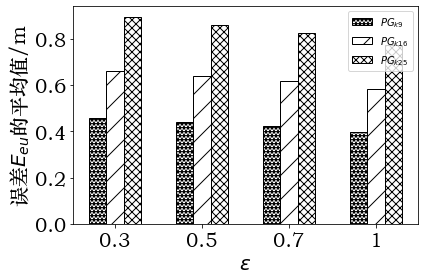

In [25]:
import numpy as np
import joblib
import math
epsilon = 1
n_x_lattice = 50
k9_pim_reports, k9_lm_reports = joblib.load(filename=f"epsilon_{epsilon}_0.jbl")
k16_pim_reports, k16_lm_reports = joblib.load(filename=f"epsilon_{epsilon}_1.jbl")
k25_pim_reports, k25_lm_reports = joblib.load(filename=f"epsilon_{epsilon}_2.jbl")

k9_2_pim_distance = ave_ave_distance(k9_pim_reports, tps[0])
k16_2_pim_distance = ave_ave_distance(k16_pim_reports, tps[1])
k25_2_pim_distance = ave_ave_distance(k25_pim_reports, tps[2])

k9_2_lm_distance = ave_ave_distance(k9_lm_reports, tps[0])
k16_2_lm_distance = ave_ave_distance(k16_lm_reports, tps[1])
k25_2_lm_distance = ave_ave_distance(k25_lm_reports, tps[2])

epsilon = 0.3
k9_pim_reports, k9_lm_reports = joblib.load(filename=f"epsilon_{epsilon}_0.jbl")
k16_pim_reports, k16_lm_reports = joblib.load(filename=f"epsilon_{epsilon}_1.jbl")
k25_pim_reports, k25_lm_reports = joblib.load(filename=f"epsilon_{epsilon}_2.jbl")

k9_03_pim_distance = ave_ave_distance(k9_pim_reports, tps[0])
k16_03_pim_distance = ave_ave_distance(k16_pim_reports, tps[1])
k25_03_pim_distance = ave_ave_distance(k25_pim_reports, tps[2])

k9_03_lm_distance = ave_ave_distance(k9_lm_reports, tps[0])
k16_03_lm_distance = ave_ave_distance(k16_lm_reports, tps[1])
k25_03_lm_distance = ave_ave_distance(k25_lm_reports, tps[2])

epsilon = 0.5
k9_pim_reports, k9_lm_reports = joblib.load(filename=f"epsilon_{epsilon}_0.jbl")
k16_pim_reports, k16_lm_reports = joblib.load(filename=f"epsilon_{epsilon}_1.jbl")
k25_pim_reports, k25_lm_reports = joblib.load(filename=f"epsilon_{epsilon}_2.jbl")

k9_05_pim_distance = ave_ave_distance(k9_pim_reports, tps[0])
k16_05_pim_distance = ave_ave_distance(k16_pim_reports, tps[1])
k25_05_pim_distance = ave_ave_distance(k25_pim_reports, tps[2])

k9_05_lm_distance = ave_ave_distance(k9_lm_reports, tps[0])
k16_05_lm_distance = ave_ave_distance(k16_lm_reports, tps[1])
k25_05_lm_distance = ave_ave_distance(k25_lm_reports, tps[2])

epsilon = 0.7
k9_pim_reports, k9_lm_reports = joblib.load(filename=f"epsilon_{epsilon}_0.jbl")
k16_pim_reports, k16_lm_reports = joblib.load(filename=f"epsilon_{epsilon}_1.jbl")
k25_pim_reports, k25_lm_reports = joblib.load(filename=f"epsilon_{epsilon}_2.jbl")

k9_1_pim_distance = ave_ave_distance(k9_pim_reports, tps[0])
k16_1_pim_distance = ave_ave_distance(k16_pim_reports, tps[1])
k25_1_pim_distance = ave_ave_distance(k25_pim_reports, tps[2])

k9_1_lm_distance = ave_ave_distance(k9_lm_reports, tps[0])
k16_1_lm_distance = ave_ave_distance(k16_lm_reports, tps[1])
k25_1_lm_distance = ave_ave_distance(k25_lm_reports, tps[2])
#汇总
k9 = [k9_03_pim_distance, k9_05_pim_distance, k9_1_pim_distance, k9_2_pim_distance]
k16 = [k16_03_pim_distance, k16_05_pim_distance, k16_1_pim_distance, k16_2_pim_distance]
k25 = [k25_03_pim_distance, k25_05_pim_distance, k25_1_pim_distance, k25_2_pim_distance]

k9l = [k9_03_lm_distance,k9_05_lm_distance,k9_1_lm_distance,k9_2_lm_distance]
k16l = [k16_03_lm_distance,k16_05_lm_distance,k16_1_lm_distance,k16_2_lm_distance]
k25l = [k25_03_lm_distance,k25_05_lm_distance,k25_1_lm_distance,k25_2_lm_distance]

def plot_bar(results, y_name, filename="图6"):
    plt.rcParams['font.sans-serif'] = ['STZhongsong']
    k9, k16, k25 = results#都是PIM运行结果
    x = np.arange(len(epsilons))
    width = 0.2
    print(epsilons)
    fig, ax = plt.subplots()# label='$PG_{k9}$'
    rects1 = ax.bar(x - width, np.array(k9) / 1000, width,color='white', alpha=1, edgecolor="k",hatch="***",label='$PG_{}$'.format("{"+'k9'+"}"))
    rects2 = ax.bar(x, np.array(k16) / 1000, width,color='white', alpha=1, edgecolor="k",hatch='/',label='$PG_{}$'.format("{"+'k16'+"}"))
    rects3 = ax.bar(x + width, np.array(k25) /1000, width,color='white', alpha=1, edgecolor="k",hatch="xxx",label='$PG_{}$'.format("{"+'k25'+"}"))
    ax.set_xticks(x)
    plt.rcParams["font.size"] = 10
    plt.legend(loc = "best", fontsize=10)
    ax.set_ylabel(u'误差$E_{}$的平均值/m'.format("{" + y_name + "}"))
    ax.set_xticklabels(epsilons)
    plt.xlabel("$\epsilon$")

    fig.tight_layout()
    #plt.savefig('E:\TRLP-master\\test'+filename + ".jpg", bbox_inches='tight', pad_inches=0,  transparent=False)
    plt.show()

plot_bar([k9, k16, k25], "eu")


#### 实验2 测试TRLP算法发布时序位置时可用性变化情况

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


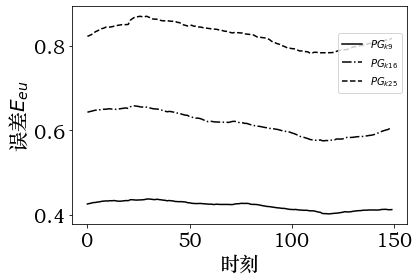

In [26]:
# Geolife数据集
k9_pim_distances = ave_distance(k9_pim_reports, tp)
k16_pim_distances = ave_distance(k16_pim_reports, tp)
k25_pim_distances = ave_distance(k25_pim_reports, tp)
plt.rcParams['font.sans-serif'] = ['STZhongsong']
plt.rcParams["font.size"] = 20
plt.ylabel("误差$E_{eu}$")
plt.xlabel("时刻")
plt.plot(smoothing(k9_pim_distances), label="$PG_{k9}$", color="black")
plt.plot(smoothing(k16_pim_distances), label="$PG_{k16}$", linestyle="-.",color="black")
plt.plot(smoothing(k25_pim_distances), label="$PG_{k25}$",linestyle="--",color="black")
plt.legend(fontsize=10, loc="upper right", bbox_to_anchor=(1,0.9))
plt.savefig("geolife.eps", bbox_inches='tight', pad_inches=0 )

# # Gawalla数据集
# Gowalla_03_pim_reports, Gowalla_03_lm_reports = joblib.load(filename=f"Gowalla_epsilon_0.3.jbl")
# Gowalla_05_pim_reports, Gowalla_05_lm_reports = joblib.load(filename=f"Gowalla_epsilon_0.5.jbl")
# Gowalla_07_pim_reports, Gowalla_07_lm_reports = joblib.load(filename=f"Gowalla_epsilon_0.7.jbl")
# Gowalla_1_pim_reports, Gowalla_1_lm_reports = joblib.load(filename=f"Gowalla_epsilon_1.jbl")
#
# #汇总
# k9 = [k9_03_pim_distance, k9_05_pim_distance, k9_1_pim_distance, k9_2_pim_distance]
# k16 = [k16_03_pim_distance, k16_05_pim_distance, k16_1_pim_distance, k16_2_pim_distance]
# k25 = [k25_03_pim_distance, k25_05_pim_distance, k25_1_pim_distance, k25_2_pim_distance]
#
# k9l = [k9_03_lm_distance,k9_05_lm_distance,k9_1_lm_distance,k9_2_lm_distance]
# k16l = [k16_03_lm_distance,k16_05_lm_distance,k16_1_lm_distance,k16_2_lm_distance]
# k25l = [k25_03_lm_distance,k25_05_lm_distance,k25_1_lm_distance,k25_2_lm_distance]
#
#
# k9_pim_distances = ave_distance(k9_pim_reports, tp)
# k16_pim_distances = ave_distance(k16_pim_reports, tp)
# k25_pim_distances = ave_distance(k25_pim_reports, tp)
# plt.rcParams['font.sans-serif'] = ['STZhongsong']
# plt.rcParams["font.size"] = 20
# plt.ylabel("误差$E_{eu}$")
# plt.xlabel("时刻")
# plt.plot(smoothing(k9_pim_distances), label="$PG_{k9}$", color="black")
# plt.plot(smoothing(k16_pim_distances), label="$PG_{k16}$", linestyle="-.",color="black")
# plt.plot(smoothing(k25_pim_distances), label="$PG_{k25}$",linestyle="--",color="black")
# plt.legend(fontsize=10, loc="upper right", bbox_to_anchor=(1,0.9))
# plt.savefig("geolife.eps", bbox_inches='tight', pad_inches=0)

#### 对比实验
与添加拉普拉斯机制的基线算法进行对比

D:\Users\juanrui\Anaconda3\envs\LDP-project\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


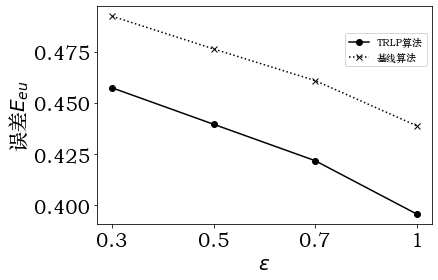

In [27]:
x = np.arange(len(epsilons))
def plot_compare(dot_l,dot_pi,graph):
    #plt.title(graph)
    plt.rcParams['font.sans-serif'] = ['STZhongsong']
    plt.rcParams["font.size"] = 20
    x = np.arange(len(epsilons))
    f,ax = plt.subplots()
    ax.set_xticklabels(epsilons)
    ax.set_xticks(x)
    plt.xlabel("$\epsilon$")
    plt.ylabel("误差$E_{eu}$")
    plt.plot(np.array(dot_pi)/1000, label="TRLP算法", marker="o",color="black")
    plt.plot(np.array(dot_l)/1000, label="基线算法", linestyle="dotted", marker="x",color="black")
    plt.legend(fontsize=10, loc="upper right", bbox_to_anchor=(1,0.9))
    plt.show()
graphs = ["GK9","GK16","GK25"]
plot_compare(k9l,k9,graphs[0])
# plot_compare(k16l,k16,graphs[1])
# plot_compare(k25l,k25,graphs[2])


25
++++++++++++++++++++++++++++++50++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++75++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++100++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++125++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++150++++++++++++++++++++++++++++++
[0.48879999999999996, 0.4656, 0.5064000000000002, 0.5535999999999999, 0.4981333333333335]
[0.9080000000000003, 0.8421333333333336, 0.818, 0.84384, 0.8794666666666666]


D:\Users\juanrui\Anaconda3\envs\LDP-project\lib\site-packages\ipykernel_launcher.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator


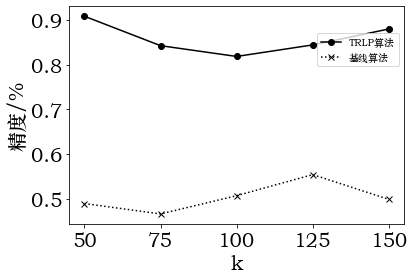

In [28]:
import sys
sys.path.append("../src")
import trajectory_processor
import joblib

k9_03_pim_distance = ave_ave_distance(k9_pim_reports, tps[0])
from sklearn.neighbors import NearestNeighbors

def knn(k,location_list):
    # 指定初查询前始位置
    lat,lng = location_list[0]

    allLocation = []
    for item in location_list:
        allLocation.append([item[0],item[1]])
    #n_neighbors give the number of output locations

    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(allLocation)
    distances, indices = knn.kneighbors([[float(lat),float(lng)]])
    R = []
    # 最近k个位置的索引
    for i in indices:
        for j in i:
            R.append(allLocation[j])
    return R

def knn_precision(origin_states,perturb_states,k):
    # 选择策略图GK9
    tp = trajectory_processor.TrajectoryProcessor(n_x_lattice)
    #tp.make_map_from_latlon(max_lat=39.988695, max_lon=116.467438, min_lat=39.831741, min_lon=116.273804)
    #n_split = tp.cp_n_split(3)
    #tp.make_graph_from_area(n_split=n_split, r=float("inf"))
    true_coords = tp.states_to_coords(origin_states)
    perturbed_coords = tp.states_to_coords(perturb_states)
    # 在真实位置数据集上的查询结果
    R_true = knn(k,true_coords)
    # 在扰动位置数据集上的查询结果
    R_perturb = knn(k,perturbed_coords)

    R_ = [k for k in R_true if k in R_perturb]
    num = len(R_)

    # todo: 计算精度和召回率
    precision = num/k
    return precision

epsilon = 0.5
k9_TRLP_reports, k9_lm_reports = joblib.load(filename=f"epsilon_{epsilon}_0.jbl")
print(len(k9_TRLP_reports[0]['perturbed_trajectories']))

# k9_lm_reports表示20个用户的轨迹数据
# k9_lm_reports[0]["true_trajectory"]表示第一个用户的原始轨迹数据
# 原始状态
origin_states_lm = k9_lm_reports[0]["true_trajectory"]
origin_states_TRLP = k9_TRLP_reports[0]["true_trajectory"]
# 扰动状态
# k9_lm_reports[0]["perturbed_trajectories"]表示重复运行扰动算法30次得到的结果

k_list = [50,75,100,125,150]
lm_precision_list = []
TRLP_precision_list = []

for k in k_list:
    print('+'*30+str(k)+'+'*30)
    precision_lm_sum = 0
    precision_TRLP_sum = 0
    for i in range(25):
        # lm机制结果
        perturb_lm_states_i = k9_lm_reports[0]['perturbed_trajectories'][i]
        precision_lm_i = knn_precision(origin_states_lm,perturb_lm_states_i,k)
        precision_lm_sum += precision_lm_i

        # TRLP结果
        perturbed_TRLP_states_i = k9_TRLP_reports[0]['perturbed_trajectories'][i]
        precision_TRLP_i = knn_precision(origin_states_TRLP,perturbed_TRLP_states_i,k)
        precision_TRLP_sum += precision_TRLP_i

    # lm平均结果
    precision_lm_ave = precision_lm_sum / 25
    lm_precision_list.append(precision_lm_ave)

    # TRLP平均结果
    precision_TRLP_ave = precision_TRLP_sum / 25
    TRLP_precision_list.append(precision_TRLP_ave)

def plot_compare(dot_lm,dot_TRLP):
    plt.rcParams['font.sans-serif'] = ['STZhongsong']
    plt.rcParams["font.size"] = 20
    x = np.arange(len(k_list))
    f,ax = plt.subplots()
    ax.set_xticklabels(k_list)
    ax.set_xticks(x)
    plt.xlabel("k")
    plt.ylabel("精度/%")
    plt.plot(dot_TRLP, label="TRLP算法", marker="o",color="black")
    plt.plot(dot_lm, label="基线算法", linestyle="dotted", marker="x",color="black")
    plt.legend(fontsize=10, loc="upper right", bbox_to_anchor=(1,0.9))
    plt.show()

print(lm_precision_list)
print(TRLP_precision_list)
plot_compare(lm_precision_list,TRLP_precision_list)
